# ECE 4420/6420 Project 1 Submission Notebook
#### Jason Baer, Devin Lane, Richard Garcia, Aaron Bruner

In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_validate,train_test_split
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier

%matplotlib inline

## Set up the Training, Validation, and Deployment Data:
A unique approach was taken in one part of this preprocessing. Aside from doing the usual column transformations provided by scikit-learn, an additional step was taken to manually split up the ```Cabin``` column into multiple columns - representative of each value between ```/``` in the original.
For example:
```B/0/P``` (one column) -----> ```B```   ```0``` ```P``` (three separate columns on same row).

This resulted in a higher training score than simply performing OHE on the original column.

In [2]:
space_train_df = pd.read_csv('./data/train.csv') # Training dataset prior to changing 'cabin' column
space_test_df = pd.read_csv('./data/test.csv') # Deployment dataset prior to changing 'cabin' column

# Want to go ahead and do some preprocessing on each (custom implementation):
# Let's deal with the slashes in the 'cabin' column first:
def cabinUpdate(df):
    # Split Cabin columns string on the slash and rename its columns
    cabinNew = df.Cabin.str.split('/', expand=True)
    cabinNew.columns = ['Cabin-1', 'Cabin-2', 'Cabin-3']
    # Copy the input dataframe to avoid mutating the original
    df1 = df.copy()
    # Add expanded columns to our copied dataframe:
    for col in cabinNew:
        df1[col] = cabinNew[col]
    # Reorder the columns in the new dataframe:
    cols = df1.columns.tolist()
    cols = cols[:3] + cols[-3:] + cols[4:-3]
    df1 = df1[cols]
    return df1

# Update our DF's structure based on the Cabin column
space_train_df = cabinUpdate(space_train_df).copy()
# Split data into train and test (for model optimization)
train_df, test_df = train_test_split(space_train_df, test_size=.2, random_state=123)
X_train, y_train = train_df.drop(columns=['Transported']), train_df['Transported']
X_test, y_test = test_df.drop(columns=['Transported']), test_df['Transported']

# For training optimized model prior to predicting outcomes:
X_train_complete = space_train_df.drop(columns=['Transported'])
y_train_complete = space_train_df[['Transported']]

# Processed deployment dataset:
space_test_df = cabinUpdate(space_test_df).copy()

# Display to user:
print('Training Dataframe:')
display(space_train_df)
print('Deployment Dataframe:')
display(space_test_df)

Training Dataframe:


,PassengerId,HomePlanet,CryoSleep,Cabin-1,Cabin-2,Cabin-3,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A,98,P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G,1499,S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G,1500,S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E,608,S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


Deployment Dataframe:


,PassengerId,HomePlanet,CryoSleep,Cabin-1,Cabin-2,Cabin-3,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G,3,S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F,4,S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C,0,S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C,1,S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F,5,S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G,1496,S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,NaN,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D,296,P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D,297,P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


## Set up Our CV, Fitting, and Scoring Function:

In [3]:
def cvfs(modelName, model_pipeline, convertToStr = False):
    '''
        Inputs:
            modelName (str) -> the name of the model to be stored in the scores dictionary
            model_pipeline (obj) -> the model (or pipeline) to be operated on
            convertToStr (bool) -> Whether to convert the labels to a string instead of bool. This is needed for catBoost
            
        This function performs cross-validation on, trains, and scores a model, saving the results into a dictionary to
        later be displayed to the user. The scoring metric is accuracy, and it is scored on the validation split of the train.csv file.
    '''
    
    # Perform cross-validation on the model (or pipeline)
    if not convertToStr:
        cvScores = cross_validate(model_pipeline, X_train, y_train.values.ravel(), cv=5, return_train_score=True)
    else:
        cvScores = cross_validate(model_pipeline, X_train, y_train.astype(str), cv=5, return_train_score=True)
    # Display the output to the user
    display(pd.DataFrame(cvScores))
    
    # Save the mean of each sub-score of CV to the dict entry associated with the model:
    modelScores[modelName] = {}
    for item in cvScores:
        modelScores[modelName][item] = np.mean(cvScores[item])
    
    # Fit the model on the training split and score it on the validation split:
    if not convertToStr:
        model_pipeline.fit(X_train, y_train.values.ravel())
        modelScores[modelName]['Accuracy'] = model_pipeline.score(X_test, y_test.values.ravel())
    else:
        model_pipeline.fit(X_train, y_train.astype(str))
        modelScores[modelName]['Accuracy'] = model_pipeline.score(X_test, y_test.astype(str))
    # Display the accuracy to the user
    print('{} Accuracy: {}'.format(modelName, modelScores[modelName]['Accuracy']))

## Set Up our Prediction Export Function

In [4]:
def predExp(fileName, predictions):
    '''
        Inputs:
            fileName (str) -> the relative path to the CSV file to save predictions
            predictions (ndarray) -> The numpy array returned from model's predict method
            
        This function streamlines the process of formatting and saving predictions to a CSV file
        which will later be uploaded to Kaggle.
    '''
    # combine the test dataset ID column with the predicted outcomes
    result = zip(space_test_df['PassengerId'], pd.Series(predictions))
    # Convert the result to a DataFrame (sorted by ID)
    out = pd.DataFrame(result, columns=['PassengerId', 'Transported']).sort_values('PassengerId')
    # Save the DF to a CSV w/o the row numbers
    out.to_csv(fileName, index=False)
    # Show description to the user
    display(out.describe())

## Part I - Exploratory Data Analysis

In [5]:
# Display some stats about our dataset:
space_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin-1       8494 non-null   object 
 4   Cabin-2       8494 non-null   object 
 5   Cabin-3       8494 non-null   object 
 6   Destination   8511 non-null   object 
 7   Age           8514 non-null   float64
 8   VIP           8490 non-null   object 
 9   RoomService   8512 non-null   float64
 10  FoodCourt     8510 non-null   float64
 11  ShoppingMall  8485 non-null   float64
 12  Spa           8510 non-null   float64
 13  VRDeck        8505 non-null   float64
 14  Name          8493 non-null   object 
 15  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(9)
memory usage: 1.0+ MB


Notice that the non-null counts indicate almost all columns are missing values - we need to use imputation!

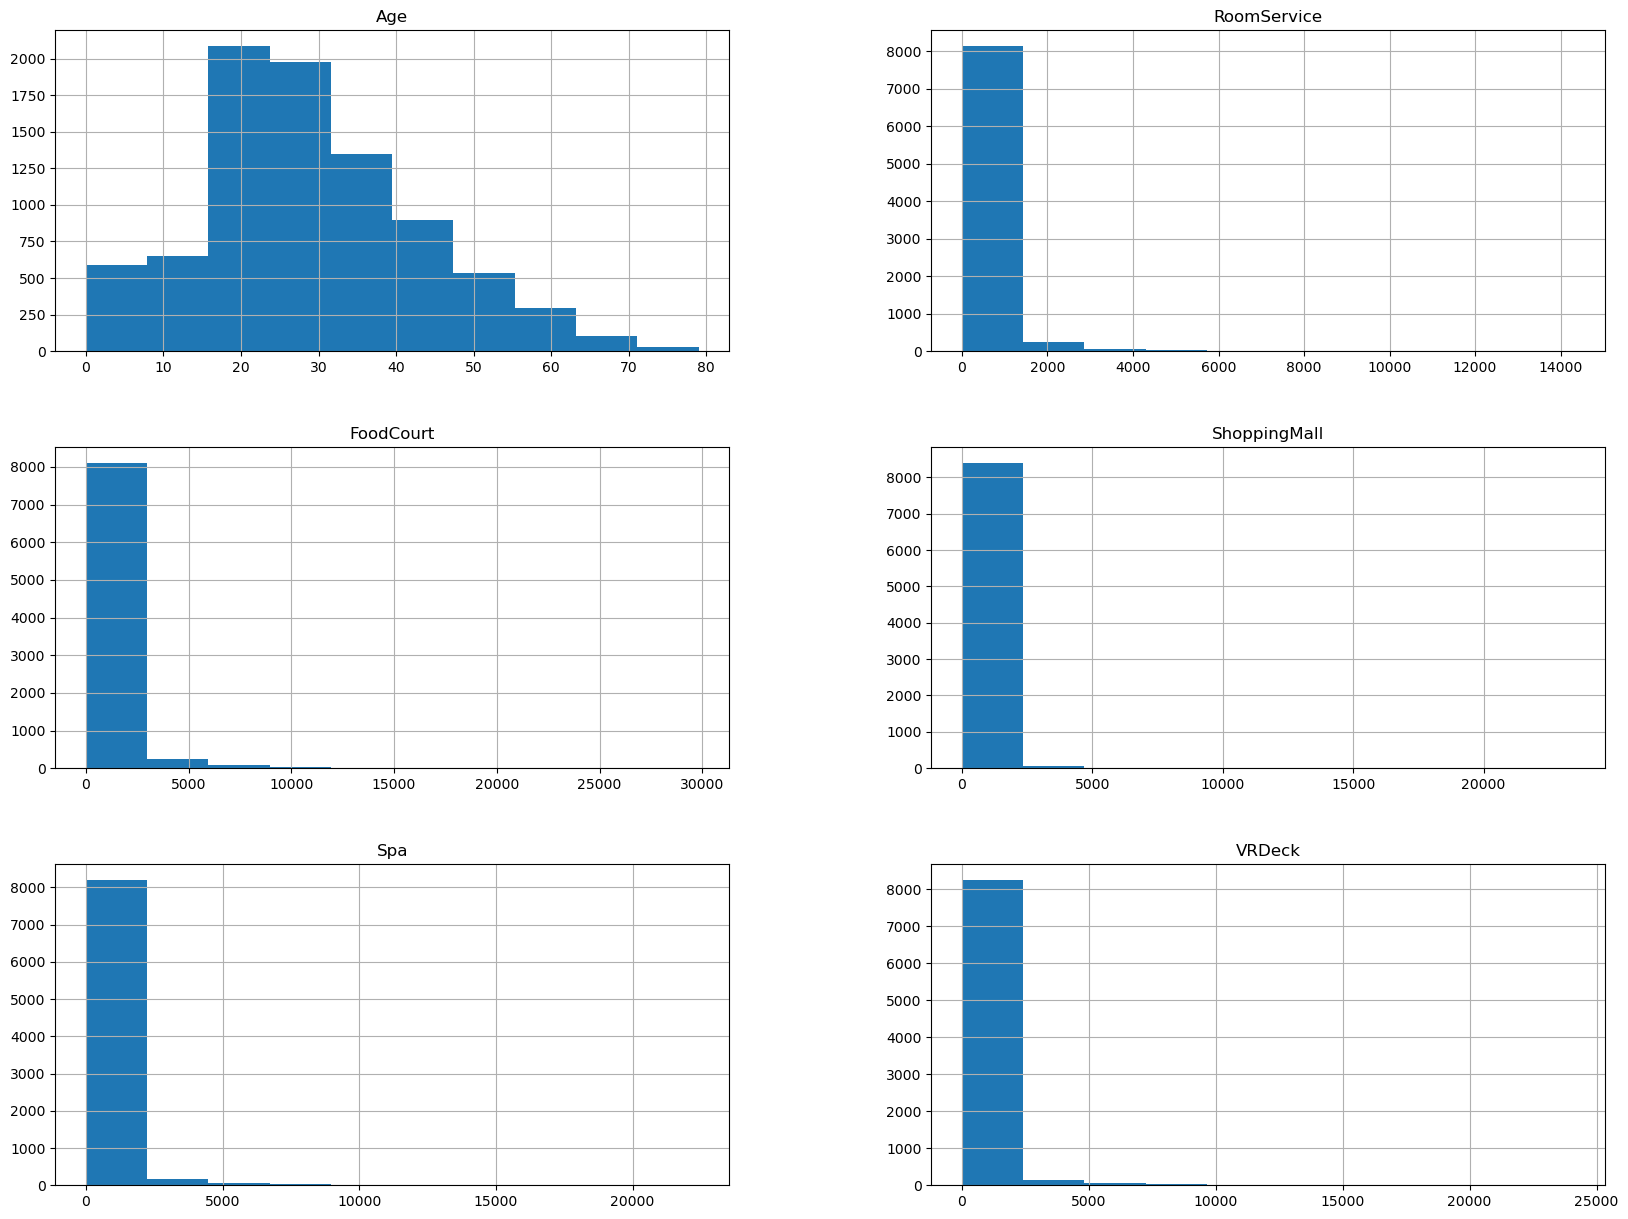

In [6]:
# Observe the distributions of our numerical features:
space_train_df.hist(figsize=(20, 15));

## Part II - Dummy Submission
Here we create a baseline to compare our later models to.

In [7]:
# For comparing our model scores
modelScores = {}

Perform cross validation to get an idea of what our Dummy classifier can do

In [8]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=123)
# Perform CV, fit, and score the model:
cvfs('Dummy Most Frequent', dummy_model)

,fit_time,score_time,test_score,train_score
0,0.000770,0.000287,0.501797,0.501887
1,0.000524,0.000216,0.501797,0.501887
2,0.000483,0.000213,0.501797,0.501887
3,0.000576,0.000225,0.501797,0.501887
4,0.000515,0.000208,0.502158,0.501797


Dummy Most Frequent Accuracy: 0.5106382978723404


In [9]:
# Now we want to train our model on entire training set and predict outcomes of deployment data to submit to competition:
# Re-fit model on entire training dataset:
dummy_model.fit(X_train_complete, y_train_complete)
# Now we need to predict the outcomes of the unseen data:
dummyPredictions = dummy_model.predict(space_test_df)

Save our predictions to a csv file (using custom function):

In [10]:
predExp('./results/dummyResult.csv', dummyPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,1
top,0013_01,True
freq,1,4277


## Part III - Preprocessing

| Feature | Transformation |
| --- | ----------- |
| HomePlanet | imputation, One-Hot Encoding |
| Cabin (or cabin-1/2/3) | imputation, One-Hot Encoding|
| Destination | imputation, One-Hot Encoding |
| Age | imputation, scaling |
| RoomService | imputation, scaling |
| FoodCourt | imputation, scaling |
| ShoppingMall | imputation, scaling |
| Spa | imputation, scaling |
| VRDeck | imputation, scaling |
| CryoSleep | imputation, One-Hot Encoding |
| VIP | imputation, One-Hot Encoding |
| name | drop |
| Transported | target |


In [11]:
# Define our categories of columns:
cat = ['HomePlanet',  'Cabin-1', 'Cabin-3', 'Destination']
num = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin-2']
binary = ['CryoSleep', 'VIP']
drop = ['Name', 'PassengerId']
target = 'Transported'
# Make the column transformer:
preprocessor = make_column_transformer(
        # Apply standard scaling to all our numeric features
        (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num),
        # Make a pipeline for our categorical features
        # 1. First fill NaN's with most frequent of each feature
        # 2. Then use one hot encoding on result
        (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat),
        # One-hot encoding of our binary column, 'sex,' so we aren't wasting space
        (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary", dtype=int,handle_unknown='ignore')), binary),
        ('drop', drop)
)

### It should be noted that we are not defining a pipeline here, as they will be different for each implementation!

## Part IV - KNN

Here we will are utilizing cross validation to find the best hyperparameter to utilize for our model

In [12]:
results_dict = {
    "neighbors": [],
    "train_accuracy": [],
    "cv_accuracy": [],
    "fit_time": [],
    "score_time": []
}

train_scores = []
test_scores = []
neighbors = []

#Find the best n_neighbors. We will be looking at odd numbers from the range 1-30 and picking
#the best n_neighbors from there.
for i in range(1, 30, 2):
    
    #create a pipeline with the preprocessor defined earlier and a kNN model with n_neighbors
    #set equal to the iterator
    pipe_hyper_knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=i))
    
    #fit on the training data
    pipe_hyper_knn.fit(X_train, y_train.values.ravel())
    
    #complete a 5-fold cv using that hyperparameter
    scores = cross_validate(pipe_hyper_knn, X_train,y_train.values.ravel(), cv=5, return_train_score = True)

    #store results in a dict
    results_dict["neighbors"].append(i)
    results_dict['train_accuracy'].append(np.mean(scores['train_score']))
    results_dict['cv_accuracy'].append(np.mean(scores['test_score']))
    results_dict['fit_time'].append(np.mean(scores['fit_time']))
    results_dict['score_time'].append(np.mean(scores['score_time']))

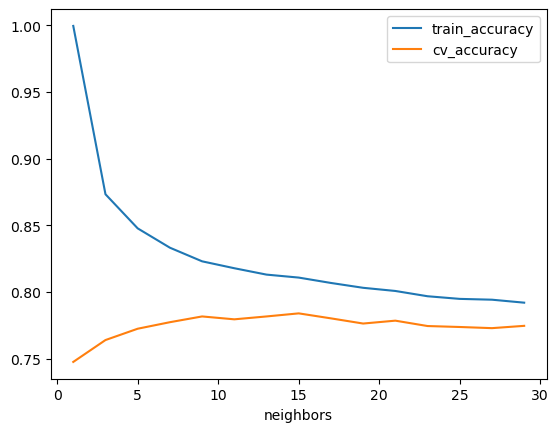

In [13]:
#using the dict, display a graph showing the training and cv accuracy based on the 
#hyperparameters tested
results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("neighbors")
results_df[["train_accuracy", "cv_accuracy"]].plot()
# Get location of max CV score: best n_neighbors = 23
best_neighbors = results_df.iloc[np.argmax(results_df.cv_accuracy)].name

In [14]:
#recreate our pipeline using the optimal n_neighbors we found and test on model on our test split
pipe_hyper_knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=best_neighbors))
# Perform CV, fit, and score the model:
cvfs('KNN {} Neighbors'.format(best_neighbors), pipe_hyper_knn)

,fit_time,score_time,test_score,train_score
0,0.017021,0.035775,0.789360,0.809815
1,0.016815,0.029664,0.789360,0.812152
2,0.015360,0.028639,0.772825,0.812331
3,0.015678,0.027260,0.780014,0.807118
4,0.015393,0.031725,0.788489,0.812725


KNN 15 Neighbors Accuracy: 0.8085106382978723


In [15]:
# Now we want to train our model on entire training set and predict outcomes of deployment data to submit to competition:
pipe_hyper_knn.fit(X_train_complete, y_train_complete.values.ravel())
# Predict the outcomes of unseen data:
kNNPredictions = pipe_hyper_knn.predict(space_test_df)

In [16]:
# Save our results in the proper format
predExp('./results/knn_with_{}_neighbors.csv'.format(best_neighbors), kNNPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,False
freq,1,2171


## Part V - Linear Regression

In [17]:
# make our pipeline with the preprocessor and logistic regression
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter = 10000),
)
# Perform CV, fit, and score the model before tuning hyperparameters:
cvfs('Linear Regression (Default C)', pipe_lr)

,fit_time,score_time,test_score,train_score
0,0.052105,0.005162,0.812365,0.785907
1,0.045154,0.004239,0.782890,0.794535
2,0.042958,0.004033,0.776420,0.791659
3,0.039998,0.004123,0.791517,0.788424
4,0.039786,0.004111,0.784173,0.790259


Linear Regression (Default C) Accuracy: 0.8062104657849338


Let's see if we can get our score up by optimizing our hyperparameter:

In [18]:
param_grid = {
    'logisticregression__C': 10.0 ** np.arange(-20, 10)
}

gridSearch = GridSearchCV(pipe_lr, param_grid, cv=5, n_jobs=-1, return_train_score=True)

from sklearn import set_config
set_config(display='diagram')

# Conveniently we can fit the GridSearch returned model on our data
gridSearch.fit(X_train, y_train)
display(gridSearch)
# Show the best score:
display(gridSearch.best_score_)
# Show the best hyperparameter:
display(gridSearch.best_params_)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Cabin-2']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_...
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
       1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
       1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])},
             return_train_score=True)

0.7903356107349923

{'logisticregression__C': 10.0}

Now we know to set C = 10 for our hyperparameter. Let's try this in our model:

### Scoring our Finalized Model

In [19]:
# Redefine pipeline
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter = 1000, C=10),
)
# Perform CV, fit, and score the optimized model:
cvfs('LR C = 10', pipe_lr)

,fit_time,score_time,test_score,train_score
0,0.043402,0.004413,0.811646,0.786985
1,0.052083,0.004468,0.787203,0.794895
2,0.034519,0.004731,0.777858,0.792378
3,0.047806,0.007231,0.790798,0.788963
4,0.028467,0.012386,0.784173,0.790798


LR C = 10 Accuracy: 0.8073605520414031


### Make and Save Our Predictions for Submission
This score looks pretty good. Let's try predicting values for submission to the competition:

In [20]:
# Now fit our pipeline on the entire training set:
pipe_lr.fit(X_train_complete, y_train_complete.values.ravel())
# Make our predictions:
lrPredictions = pipe_lr.predict(space_test_df)

In [21]:
# Save our results in the proper format
predExp('./results/lr_C_10.csv', lrPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2262


## Part VI - Ensembles
NOTE: This section uses hyperparameter tuning for Random Forest, XGBoost, and CatBoost. The grid searching is indicated and placed within a 'Raw' cell to supress running. The best parameter values were found and hardcoded into the classifiers so that it works without spending large amounts of time waiting for the grid search to finish. If you would like to run the tuning yourself, just change the cell from 'Raw' to 'Code'.

### Random Forest

In [22]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123, n_jobs=-1))
# Perform CV, fit, and score the model:
cvfs('Random Forests', pipe_rf)

,fit_time,score_time,test_score,train_score
0,0.229496,0.020223,0.802301,0.999101
1,0.119126,0.017792,0.806614,0.999101
2,0.103915,0.017982,0.785766,0.999640
3,0.113065,0.018111,0.793674,0.999281
4,0.114323,0.017827,0.786331,0.999820


Random Forests Accuracy: 0.8205865439907993


In [23]:
# Make our predictions:
pipe_rf.fit(X_train_complete, y_train_complete.values.ravel())
rfPredictions = pipe_rf.predict(space_test_df)
# Save our predictions:
predExp('./results/random_forest.csv', rfPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,False
freq,1,2292


#### RF Hyperparameters

In [24]:
# Create the random grid and define classifier
rf_grid = {'randomforestclassifier__n_estimators': range(100,300,20),
               'randomforestclassifier__criterion': ['gini','entropy'],
               'randomforestclassifier__max_depth': range(2,10,1)}

The below cell is for finding optimal hyperparameters. Change to 'Code' to run.

In [25]:
rf_best = make_pipeline(preprocessor,RandomForestClassifier(n_estimators=120,max_depth=9,criterion='entropy'))
cvfs('RF Hyper',rf_best)

,fit_time,score_time,test_score,train_score
0,0.352081,0.017382,0.808052,0.849182
1,0.344583,0.017056,0.810208,0.844149
2,0.344929,0.017257,0.785766,0.850440
3,0.342119,0.017070,0.798706,0.846486
4,0.345263,0.016758,0.798561,0.846154


RF Hyper Accuracy: 0.8154111558366878


Here we see that the score with hyperparameter tuning is lower than the score without. However, the prediction score when submitted to Kaggle is around 1% higher with tuning.

In [26]:
rf_best.fit(X_train_complete, y_train_complete.values.ravel())
rfBestPredictions = pipe_rf.predict(space_test_df)
# Save our predictions:
predExp('./results/random_forest_hyper.csv', rfBestPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,False
freq,1,2292


### XGBOOST

In [27]:
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0, use_label_encoder=False))
# Perform CV, fit, and score the model:
cvfs('XGBoost', pipe_xgb)
# Make our predictions:
pipe_xgb.fit(X_train_complete, y_train_complete.values.ravel())
xgbPredictions = np.where(pipe_xgb.predict(space_test_df), 'True', 'False') # needed to convert integers to boolean values here

,fit_time,score_time,test_score,train_score
0,0.457907,0.008148,0.796549,0.944994
1,0.425417,0.007036,0.789360,0.947151
2,0.475890,0.007246,0.796549,0.946072
3,0.556418,0.007601,0.795830,0.941758
4,0.729049,0.007605,0.791367,0.947879


XGBoost Accuracy: 0.8136860264519838


In [28]:
# Save our results:
predExp('./results/xgboost.csv', xgbPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,False
freq,1,2141


#### Hyperparameters

In [29]:
xgb_param = {"xgbclassifier__learning_rate"    : [0.05, 0.10, 0.20, 0.30 ] ,
               "xgbclassifier__max_depth"        : range(2,8,2),
               "xgbclassifier__min_child_weight" : range(1,8,4),
               "xgbclassifier__gamma"            : [ 0.0, 0.2 , 0.4 ],
               "xgbclassifier__colsample_bytree" : [ 0.3, 0.5 , 0.7 ] }

The below cell is for finding optimal hyperparameters. Change to 'Code' to run.

In [30]:
xgb_best = make_pipeline(preprocessor, XGBClassifier(colsample_bytree=.5,gamma=.2,learning_rate=.1,max_depth=6,min_child_weight=5,use_label_encoder=False,eval_metric='logloss'))
cvfs("XGB Hyper",xgb_best)

,fit_time,score_time,test_score,train_score
0,0.416138,0.007155,0.814522,0.857811
1,0.398206,0.007679,0.808771,0.859069
2,0.392092,0.008402,0.800863,0.860507
3,0.380951,0.007280,0.803738,0.861945
4,0.388197,0.005747,0.815827,0.861251


XGB Hyper Accuracy: 0.8246118458884416


In [31]:
xgb_best.fit(X_train_complete, y_train_complete.values.ravel())
xgbBestPredictions = np.where(xgb_best.predict(space_test_df), 'True', 'False') # needed to convert integers to boolean values here
# Save our predictions:
predExp('./results/xgboost_hyper.csv', xgbBestPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2190


With tuning, the accuracy increases from 81.36% to 82.8%. This also carries over to the Kaggle submission with the prediction score increasing from 78% to 80.3%. This is our highest score for an individual model!

### Cat Boost
#### Preprocessing Changes
Catboost says on their website not to use one hot encoding for categorical variables as it is less efficient. We tried switching one hot for feature encoding, target encoding, and no encoding, but none of them made a noticable difference.

In [32]:
pipe_catboost = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=123))
# Perform CV, fit, and score the model:
cvfs('CatBoost', pipe_catboost, convertToStr=True)
# Make our predictions:
pipe_catboost.fit(X_train_complete, y_train_complete.values.ravel())
cbPredictions = pipe_catboost.predict(space_test_df)

,fit_time,score_time,test_score,train_score
0,2.456815,0.020110,0.814522,0.883696
1,2.421104,0.010218,0.815241,0.882797
2,2.510631,0.011669,0.800144,0.884415
3,2.536162,0.009933,0.808771,0.883696
4,2.530806,0.009618,0.815827,0.883717


CatBoost Accuracy: 0.8297872340425532


In [33]:
# Save our predictions:
predExp('./results/catboost.csv', cbPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2190


#### Hyperparameters
Although hyperparameter tuning is not needed for CatBoost, we will try to see if we can can better results.

In [34]:
cb_params = {'catboostclassifier__depth': [4,6,8,10],
           'catboostclassifier__random_strength': [0,3,6,10],
           'catboostclassifier__learning_rate': [.001, .005, .01]}

The below cell is for finding optimal hyperparameters. Change to 'Code' to run.

In [35]:
cb_hyper = make_pipeline(preprocessor, CatBoostClassifier(depth=4,learning_rate=.001,random_strength=0,verbose=0))
cvfs("CB Hyper",cb_hyper,convertToStr=True)

,fit_time,score_time,test_score,train_score
0,1.613715,0.009545,0.782890,0.777099
1,1.630346,0.009485,0.787922,0.782312
2,1.643702,0.009534,0.758447,0.780334
3,1.616583,0.009513,0.776420,0.783031
4,1.617677,0.009500,0.761871,0.775881


CB Hyper Accuracy: 0.7878090856814262


This score is much worse than without hyperparameter tuning. Despite searching the grid for more than 15 minutes, we were unable to get a better score. On CatBoost's website they explain that the features to stop overfitting and to generate the learning curve are already built in! This means that unless you search every possible hyper parameter, you probably will not get a better result.

In [36]:
cb_hyper.fit(X_train_complete, y_train_complete.values.ravel())
cbHyperPredictions = cb_hyper.predict(space_test_df)
# Save our predictions:
predExp('./results/catboost_hyper.csv', cbHyperPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,False
freq,1,2329


### LightGBM

In [37]:
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
# Perform CV, fit, and score the model:
cvfs('LightGBM', pipe_lgbm)

,fit_time,score_time,test_score,train_score
0,1.634572,0.010554,0.806614,0.899155
1,1.641945,0.006772,0.808771,0.899874
2,1.744299,0.008305,0.792955,0.900234
3,1.528218,0.007996,0.800144,0.902750
4,1.823761,0.006467,0.813669,0.902229


LightGBM Accuracy: 0.8257619321449109


In [38]:
# Make our predictions:
pipe_lgbm.fit(X_train_complete, y_train_complete.values.ravel())
lgbmPredictions = pipe_lgbm.predict(space_test_df)

In [39]:
# Save our predictions:
predExp('./results/lgbm.csv', lgbmPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2192


## Part VII - Averaging
We can use all our previous models in combination to allow them to 'vote' on the label at prediction time. We average the outputs of each estimator to give us the "final" answer.

Note - We already know that Random Forests and XGBoost with the hyperparameter tuning perform better on Kaggle, even if our validation score doesn't match. We'll use these instead of the unoptimized versions.

In [40]:
# Set our classifiers:
classifiers = {
    'Logistic Regression': pipe_lr,
    'KNN': pipe_hyper_knn,
    'Random Forest': rf_best,
    'XGBoost': xgb_best,
    'CatBoost': pipe_catboost,
    'LGBM': pipe_lgbm
}
from sklearn.ensemble import VotingClassifier

# Set our averaging model:
averaging_model = VotingClassifier(list(classifiers.items()), voting='soft')
averaging_model

VotingClassifier(estimators=[('Logistic Regression',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer()),
                                                                                                ('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['Age',
                                                                                 'RoomService',
                                                                                 'FoodCourt',
                                                                                 'ShoppingMall',
                                                                                 'Spa',
                                                                                 'VRDeck',
                                                                                 'Cabin-2']),
                                                                               ('pipeline-2',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 Simple...
                                                                                 'Cabin-1',
                                                                                 'Cabin-3',
                                                                                 'Destination']),
                                                                               ('pipeline-3',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               dtype=<class 'int'>,
                                                                                                               handle_unknown='ignore'))]),
                                                                                ['CryoSleep',
                                                                                 'VIP']),
                                                                               ('drop',
                                                                                'drop',
                                                                                ['Name',
                                                                                 'PassengerId'])])),
                                              ('lgbmclassifier',
                                               LGBMClassifier(random_state=123))]))],
                 voting='soft')

In [41]:
# Perform CV, fit, and score the model:
cvfs('Averaging', averaging_model)

,fit_time,score_time,test_score,train_score
0,4.705804,0.177932,0.813803,0.865360
1,4.633072,0.179952,0.815241,0.864102
2,4.565442,0.192599,0.796549,0.868237
3,4.506015,0.186619,0.803738,0.867338
4,5.427639,0.205119,0.813669,0.864306


Averaging Accuracy: 0.8257619321449109


It looks like this model is doing pretty well! Let's generate a submission CSV file from it. (Note - this resulted in our best score on Kaggle)

In [42]:
# Make our predictions:
averaging_model.fit(X_train_complete, y_train_complete.values.ravel())
avgPredictions = averaging_model.predict(space_test_df)

In [43]:
predExp('./results/averaging.csv', avgPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2192


## Part VIII - Stacking
Instead of averaging estimator outputs,final_estimator=can use these outputs as inputs to a different model. By default it is linear regression; we will also try using KNN as our final estimator. We will remove CatBoost from our model for speed purposes.

In [44]:
del classifiers['CatBoost']

In [45]:
from sklearn.ensemble import StackingClassifier
stacking_model = StackingClassifier(list(classifiers.items()))
# Perform CV, fit, and score the model:
cvfs('Stacking', stacking_model)

,fit_time,score_time,test_score,train_score
0,12.573367,0.175958,0.818116,0.869495
1,12.965862,0.171628,0.807333,0.871292
2,13.905576,0.178970,0.799425,0.871292
3,13.423653,0.184121,0.808052,0.870394
4,12.971767,0.175958,0.815108,0.863587


Stacking Accuracy: 0.8257619321449109


Let's try changing our final estimator to KNN (5 neighbors):

In [46]:
stacking_model_knn = StackingClassifier(list(classifiers.items()), final_estimator=KNeighborsClassifier())
# Test our model's performance (skip cross-validation because of time):
stacking_model_knn.fit(X_train, y_train)
modelScores['Stacking - Final is KNN'] = stacking_model_knn.score(X_test, y_test.ravel())
print('Stacking score (KNN): {}'.format(modelScores['Stacking - Final is KNN']))

Stacking score (KNN): 0.7987349051178838


Using KNN instead of Logistic Regression results in a lower score, so we won't use this to make our final predictions.

In [47]:
# Make our predictions:
stacking_model.fit(X_train_complete, y_train_complete.values.ravel())
stackingPredictions = stacking_model.predict(space_test_df)

In [48]:
# Save our predictions:
predExp('./results/stacking.csv', stackingPredictions)

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2245


## Compare Validation Scores
Since we only have 10 submissions on kaggle per day, it would be nice to choose the best models to upload results for. We can do this by observing validation scores:

In [49]:
df = pd.DataFrame.from_dict(modelScores).T.sort_values(by=['Accuracy'])
# df.columns = ['Score']
df

,fit_time,score_time,test_score,train_score,Accuracy
Dummy Most Frequent,0.000574,0.000230,0.501869,0.501869,0.510638
CB Hyper,1.624405,0.009515,0.773510,0.779731,0.787809
Stacking - Final is KNN,0.798735,0.798735,0.798735,0.798735,0.798735
Linear Regression (Default C),0.044000,0.004334,0.789473,0.790157,0.806210
LR C = 10,0.041255,0.006646,0.790336,0.790804,0.807361
KNN 15 Neighbors,0.016053,0.030613,0.784010,0.810828,0.808511
XGBoost,0.528936,0.007527,0.793931,0.945571,0.813686
RF Hyper,0.345795,0.017105,0.800259,0.847282,0.815411
Random Forests,0.135985,0.018387,0.794937,0.999389,0.820587
XGB Hyper,0.395117,0.007253,0.808744,0.860116,0.824612


Looks like we will use the five highest scores along with RF Hyper (since we know it is better on kaggle) as our submissions:

1. CatBoost
2. Stacking
3. LightGBM
4. XGB with Hyperparameter Tuning
5. Averaging
6. Random Forests with Hyperparameter Tuning

# Upload CSV's to kaggle:

Change the following cell to 'code' to run and upload notebooks. This is skipped because of the 10 submission-per-day limit. However, the correct output is included as an image for illustration purposes.

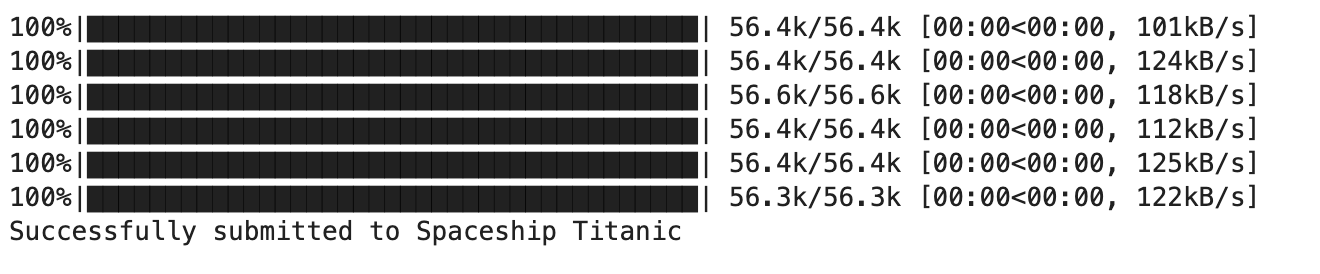

# Display Kaggle Competition Submission Results:
We will only display the top 6 *unique* scores - meaning no duplicates for the same csv file.

In [56]:
compResults = !command kaggle competitions submissions spaceship-titanic --csv

By Score:

In [55]:
pd.DataFrame([sub.split(',') for sub in compResults[1:]], columns = compResults[0].split(',')).sort_values(by=['publicScore'], ascending=False)

,fileName,date,description,status,publicScore,privateScore
0,stacking.csv,2022-12-10 00:01:43,Uploaded from API,complete,0.80289,
17,averaging.csv,2022-12-06 04:17:28,averaging of all classifiers,complete,0.80196,
14,averaging.csv,2022-12-09 01:02:04,averaging w/ LR and KNN,complete,0.80196,
5,averaging.csv,2022-12-10 00:01:34,Uploaded from API,complete,0.80173,
12,stacking.csv,2022-12-09 01:14:45,stacking with CB final,complete,0.80173,
30,cbWithCabinResult.csv,2022-11-25 19:13:17,,complete,0.80149,
10,averaging.csv,2022-12-09 02:29:56,Uploaded from API,complete,0.80102,
11,averaging.csv,2022-12-09 02:21:00,testing API,complete,0.80102,
1,catboost.csv,2022-12-10 00:01:41,Uploaded from API,complete,0.80079,
21,catboost.csv,2022-11-29 03:26:48,CB with updated notebook,complete,0.80079,


By Date:

In [53]:
pd.DataFrame([sub.split(',') for sub in compResults[1:]], columns = compResults[0].split(',')).sort_values(by=['date'], ascending=False)

,fileName,date,description,status,publicScore,privateScore
0,stacking.csv,2022-12-10 00:01:43,Uploaded from API,pending,,
1,catboost.csv,2022-12-10 00:01:41,Uploaded from API,complete,0.80079,
2,xgboost_hyper.csv,2022-12-10 00:01:39,Uploaded from API,complete,0.80079,
3,random_forest_hyper.csv,2022-12-10 00:01:37,Uploaded from API,complete,0.78933,
4,lgbm.csv,2022-12-10 00:01:35,Uploaded from API,complete,0.79845,
5,averaging.csv,2022-12-10 00:01:34,Uploaded from API,complete,0.80173,
6,lr_C_10.csv,2022-12-09 02:30:12,Uploaded from API,complete,0.79331,
7,xgboost.csv,2022-12-09 02:30:08,Uploaded from API,complete,0.00000,
8,lgbm.csv,2022-12-09 02:30:03,Uploaded from API,complete,0.79845,
9,random_forest.csv,2022-12-09 02:30:00,Uploaded from API,complete,0.78933,
